In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [48]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc.csv")

In [49]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Category'])

In [50]:
tagged_train = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train['Resume_str'])]
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test['Resume_str'])]

In [51]:
d2v_model = Doc2Vec(
    vector_size=200, 
    window=5,
    min_count=2,
    dm=0,
    epochs=20,
    workers=8
)

In [52]:
d2v_model.build_vocab(tagged_train)
d2v_model.train(tagged_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [53]:
X_train = np.array([d2v_model.dv[str(i)] for i in range(len(tagged_train))])
y_train = train['Category']

In [54]:
X_test = np.array([d2v_model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test['Category']

In [55]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 200)
Validation data size: (497, 200)


### Support Vector Classifier

In [56]:
# '''
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: f{results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")
# '''

In [57]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [58]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: ['ARTS', 'TEACHER', 'APPAREL', 'DIGITAL-MEDIA', 'AGRICULTURE', 'AUTOMOBILE', 'BPO']


In [59]:
pipeline = Pipeline([
    ('normalizer', Normalizer(norm='l2')),
    # ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [60]:
param_grid = [
    {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    verbose=3,
    n_jobs=-1,
    return_train_score=True,
)

start = time()
grid_search = grid.fit(X_train, y_train)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")

report(grid_search.cv_results_)
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
GridSearchCV took 1.64 seconds for 4 candidates parameter settings.

Model with rank: 1
Mean validation score: f0.570 (std: 0.016)
Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 2
Mean validation score: f0.566 (std: 0.014)
Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 3
Mean validation score: f0.412 (std: 0.020)
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 4
Mean validation score: f0.048 (std: 0.004)
Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [61]:
print(grid_search.best_params_)

{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [62]:
# DataFrame con i risultati
results = pd.DataFrame(grid.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")


In [63]:
LR_Model_best = grid_search.best_estimator_
prediction = LR_Model_best.predict(X_test)

In [64]:
print("Training Score: {:.2f}".format(LR_Model_best.score(X_train, y_train)))
print("Test Score: {:.2f}".format(LR_Model_best.score(X_test, y_test)))

Training Score: 0.74
Test Score: 0.61


In [65]:
print(classification_report(y_test, prediction, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.61      0.83      0.70        24
              ADVOCATE       0.33      0.17      0.22        24
           AGRICULTURE       0.53      0.62      0.57        13
               APPAREL       0.56      0.26      0.36        19
                  ARTS       0.36      0.19      0.25        21
            AUTOMOBILE       0.36      0.57      0.44         7
              AVIATION       0.75      0.75      0.75        24
               BANKING       0.71      0.65      0.68        23
                   BPO       0.20      0.25      0.22         4
  BUSINESS-DEVELOPMENT       0.46      0.67      0.54        24
                  CHEF       0.85      0.71      0.77        24
          CONSTRUCTION       0.64      0.73      0.68        22
            CONSULTANT       0.80      0.17      0.29        23
              DESIGNER       0.78      0.67      0.72        21
         DIGITAL-MEDIA       0.71      

<Figure size 1500x1000 with 0 Axes>

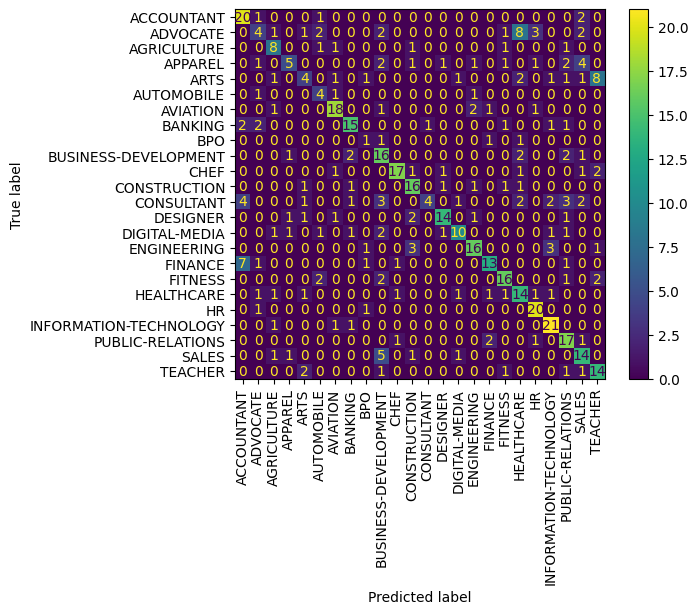

In [66]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

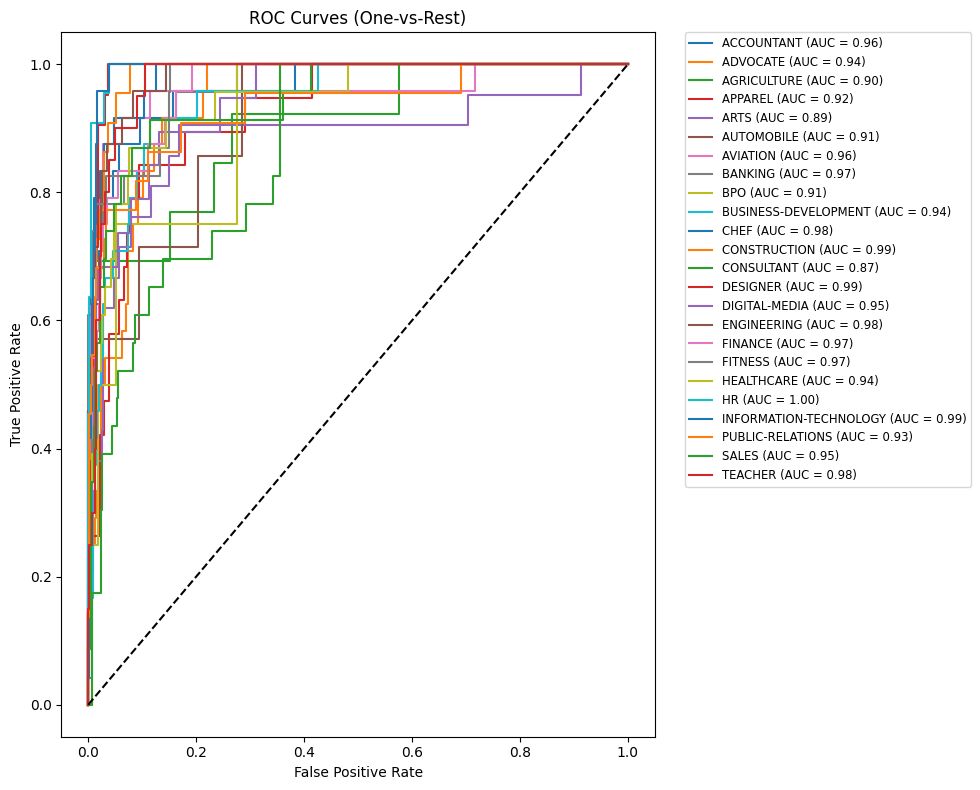

In [67]:
y_test_bin = label_binarize(y_test, classes=LR_Model_best.classes_)
y_score = LR_Model_best.predict_proba(X_test)

plt.figure(figsize=(10, 8))

for i in range(len(LR_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LR_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

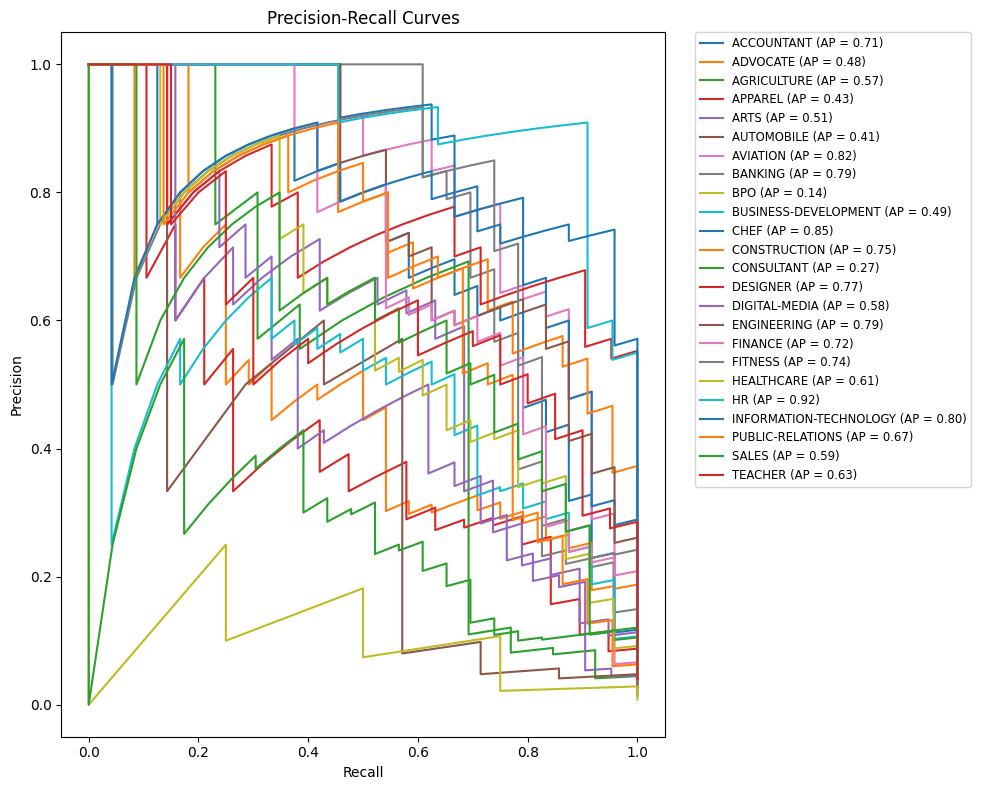

In [68]:
plt.figure(figsize=(10, 8))

for i in range(len(LR_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{LR_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [69]:
import sys
sys.path.append('..')

from utils import save_experiment_D2V

save_experiment_D2V(d2v_model, grid_search, LR_Model_best, X_train, y_train, X_test, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
LogisticRegression(clf__C=1, clf__penalty=l2, clf__solver=lbfgs) | D2V(vector_size=200, window=5, min_count=2, dm=False, epochs=20) | Accuracy train=0.740, test=0.606

